This is version 2 of the notebook using the dataset with actual response variables.

# TODO

- NEED MORE DATA POINTS
- dendrogram: which groups are closest
- ask Cory whether inverse PCA transformation can be used to get transformation for future data points to be comparable (the 'index' idea)

In [1]:
%load_ext autoreload
%autoreload 2
import warnings; warnings.simplefilter('ignore')

import pandas as pd
import numpy as np
from vacou import *
from plots import *

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set(color_codes=True)
sns.set(style="white")
#sns.set(font="monospace")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
data_fp = '/P/vacou/SS31_gait_data_for_PCA.tsv'
#d_orig = pd.read_csv(data_fp, sep='\t')

In [22]:
d, md, full_df = preprocess_vc(data_fp, version = 2)

In [28]:
response_column = 'NVC'

# Exploratory

In [19]:
full_df.columns.tolist()[:20]

['Group',
 'Animal',
 'Run_Duration_(s)_Mean',
 'Run_Average_Speed_(cm/s)_Mean',
 'Run_Maximum_Variation_(%)_Mean',
 'RF_Stand_(s)_Mean',
 'RF_StandIndex_Mean',
 'RF_MaxContactAt_(%)_Mean',
 'RF_MaxContactArea_(cm²)_Mean',
 'RF_MaxContactMaxIntensity_Mean',
 'RF_MaxContactMeanIntensity_Mean',
 'RF_PrintLength_(cm)_Mean',
 'RF_PrintWidth_(cm)_Mean',
 'RF_PrintArea_(cm²)_Mean',
 'RF_MaxIntensityAt_(%)_Mean',
 'RF_MaxIntensity_Mean',
 'RF_MinIntensity_Mean',
 'RF_MeanIntensity_Mean',
 'RF_MeanIntensityOfThe15MostIntensePixels_Mean',
 'RF_Swing_(s)_Mean']

In [13]:
d.describe()

,Run_Duration_(s)_Mean,Run_Average_Speed_(cm/s)_Mean,Run_Maximum_Variation_(%)_Mean,RF_Stand_(s)_Mean,RF_StandIndex_Mean,RF_MaxContactAt_(%)_Mean,RF_MaxContactArea_(cm²)_Mean,RF_MaxContactMaxIntensity_Mean,RF_MaxContactMeanIntensity_Mean,RF_PrintLength_(cm)_Mean,...,Couplings_LF->LH_Mean,Couplings_RH->RF_Mean,Couplings_LH->LF_Mean,Support_Zero_(%),Support_Single_(%),Support_Diagonal_(%),Support_Girdle_(%),Support_Lateral_(%),Support_Three_(%),Support_Four_(%)
count,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,...,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000
mean,4.631186,15.492489,51.529949,0.230433,-3.023624,39.615562,0.428536,142.793486,73.484871,0.986736,...,51.402888,49.650134,48.672825,0.018159,1.230350,56.223378,2.212682,0.706064,30.573390,9.035976
std,0.826640,4.447181,16.465925,0.034025,0.774734,5.762326,0.108228,16.103326,8.310848,0.137407,...,2.859577,3.050002,2.735637,0.087132,0.819881,8.201361,3.292262,0.599458,5.838240,4.262897
min,2.743659,8.233310,23.000000,0.164427,-5.539478,25.672339,0.214033,106.707317,58.552967,0.751865,...,44.958675,44.082026,42.860225,0.000000,0.000000,41.612903,0.182983,0.000000,14.995788,2.623360
25%,3.985813,13.795579,42.000000,0.201762,-3.471036,34.480518,0.358367,135.054054,66.615342,0.883123,...,49.332052,47.632508,46.883446,0.000000,0.618812,48.133199,0.448430,0.178333,26.779463,5.412794
50%,4.605380,14.787200,50.200000,0.235737,-2.845816,40.175398,0.438507,142.527778,70.556728,1.014476,...,51.333774,49.389468,48.719175,0.000000,1.191121,57.310268,0.911641,0.631136,30.180426,8.791209
75%,5.361413,16.656712,59.400000,0.259026,-2.522384,42.746750,0.513800,152.180556,81.102032,1.105587,...,53.907987,51.406669,50.538607,0.000000,1.693480,62.602515,2.274642,0.950570,34.510595,11.486963
max,6.077211,36.367256,99.100000,0.288616,-1.907316,52.107865,0.646166,174.225000,88.569989,1.205004,...,56.722779,59.350832,54.737913,0.578035,3.660886,68.508706,13.068845,2.204262,41.624365,19.700461


In [20]:
md.head()

,Group,Animal,NVC
Animal,,,
1.1,young ctrl,1.1,11.528
1.2,young ctrl,1.2,11.979
1.3,young ctrl,1.3,13.460
1.4,young ctrl,1.4,8.192
3.2,young ctrl,3.2,8.362


In [15]:
pd.DataFrame(md.Group.value_counts())

,Group
ss31 aged injected,20
young ctrl,15
Aged Ctrl,10


# Top important features

### highest variance selection

In [25]:
selected_v, variances = sel_var(normalize_pd(d, 0), 0.001)

In [26]:
print("Features with highest variance")
pd.DataFrame(variances.sort_values(ascending=False)[:15], columns = ['variance (after normalisation)'])

Features with highest variance


,variance (after normalisation)
Support_Zero_(%),0.021277
StepSequence_RB_(%),0.020404
StepSequence_RA_(%),0.018752
Support_Girdle_(%),0.015200
StepSequence_NumberOfPatterns,0.010680
OtherStatistics_NumberOfSteps,0.010404
PhaseDispersions_RF->RH_Mean_delta,0.009309
Support_Lateral_(%),0.009187
PhaseDispersions_LH->RH_Mean_delta,0.008000
PhaseDispersions_LF->RF_Mean_delta,0.007583


### f regression selection

In [30]:
selected_a = sel_anova(normalize_pd(d, 0), md[response_column], k=15)

In [31]:
print("Features selected by f_regression")
pd.DataFrame(selected_a.columns)

Features selected by f_regression


,0
0,RF_MaxContactMeanIntensity_Mean
1,RF_MinIntensity_Mean
2,RF_MeanIntensity_Mean
3,RH_MinIntensity_Mean
4,LF_MaxContactMeanIntensity_Mean
5,LF_MinIntensity_Mean
6,LF_MeanIntensity_Mean
7,LH_MinIntensity_Mean
8,FP_MaxContactMeanIntensity_Mean
9,FP_MinIntensity_Mean


### mutual information regression selection

In [32]:
selected_m = sel_mi(normalize_pd(d, 0), md[response_column], k=15)

In [33]:
print("Features selected by mutual_info_regression")
pd.DataFrame(selected_m.columns)

Features selected by mutual_info_regression


,0
0,RF_MaxIntensityAt_(%)_Mean
1,RF_MinIntensity_Mean
2,RH_MaxContactArea_(cm²)_Mean
3,RH_PrintLength_(cm)_Mean
4,RH_PrintArea_(cm²)_Mean
5,LF_PrintLength_(cm)_Mean
6,LF_MinIntensity_Mean
7,LH_PrintLength_(cm)_Mean
8,FP_PrintLength_(cm)_Mean
9,FP_MinIntensity_Mean


### Comparison of feature reduction methods

In [36]:
print("Number of selected features that overlap between methods (out of 15):")
print(' - var-f_reg:', str(sum([i in selected_a.columns.tolist()
                              for i in variances.sort_values(ascending=False)[:15].index.tolist()])),
                             "features.")
print(' - var-mi_reg:', str(sum([i in selected_m.columns.tolist()
                              for i in variances.sort_values(ascending=False)[:15].index.tolist()])),
                             "features.")
print(' - f_reg-mi_reg:', str(sum([i in selected_a.columns.tolist()
                              for i in selected_m.columns.tolist()])),
                             "features. \nWell, more than for dummy response.")

Number of selected features that overlap between methods (out of 15):
 - var-f_reg: 2 features.
 - var-mi_reg: 3 features.
 - f_reg-mi_reg: 6 features. 
Well, more than for dummy response.


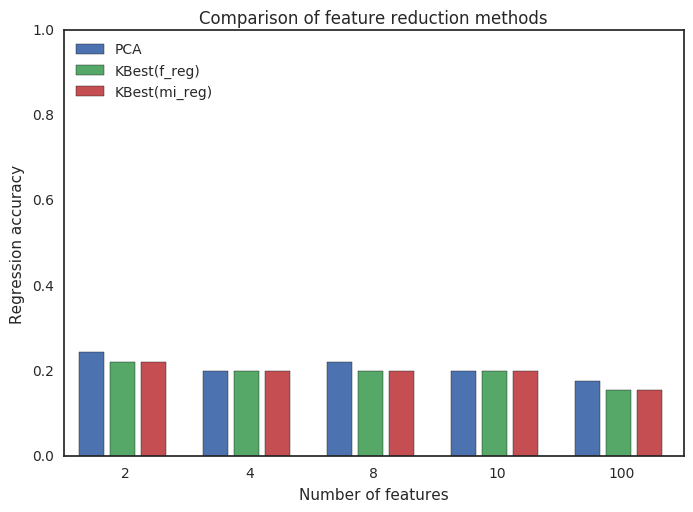

In [47]:
compare_dim_red_methods(normalize_pd(d, 0), round(md[response_column], 0))

# PCA

In [37]:
comps, exvar, _ = get_pc(normalize_pd(d,0, 'normalize'),2)

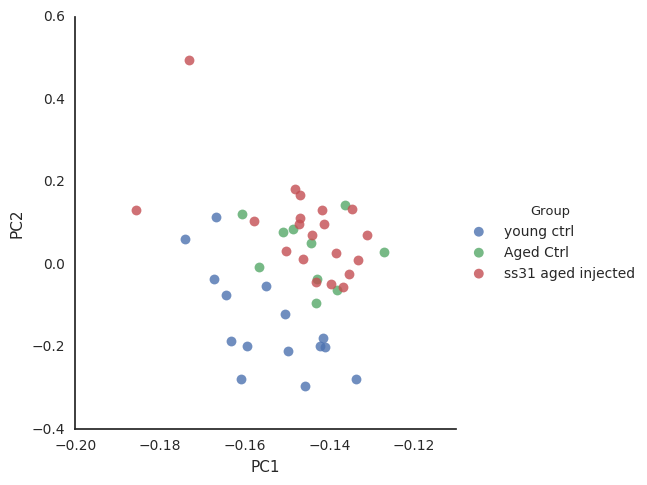

In [38]:
plot_comps = get_plot_comps(comps, md)
p2 = sns.lmplot(x='PC1', y='PC2', hue='Group', data=plot_comps, ci=None, fit_reg=False,
               scatter_kws={"s":50})

The first two components seem to actually cluster both aged groups together, with some difference between the 'aged' cluster and 'young' cluster. There are some outliers from the Group 'aged treated'...

In [40]:
#p2 = sns.lmplot(x='PC1', y='PC2', hue='Trial', data=plot_comps.sort_values('Trial').iloc[:10,:],
#                ci=None, fit_reg=False, scatter_kws={"s":50})#, y_jitter=0.01, x_jitter=0.01)

# Notes

In [ ]:
# heatmap: linkages!
p3.dendrogram_col.linkage # linkage matrix for columns
p3.dendrogram_row.linkage # linkage matrix for rows